In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./telescope_data/telescope_data.csv")
df.head()

,Unnamed: 0,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [3]:
df['class'].value_counts()

class
g    12332
h     6688
Name: count, dtype: int64

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [5]:
df_gamma= df[df['class'] == 'g']
df_hadrons= df[df['class'] == 'h']

In [6]:
size = len(df_hadrons)
df_gamma_undersampled = df_gamma.sample(n=size,random_state=42)

In [7]:
df_ready = pd.concat([df_gamma_undersampled,df_hadrons]).reset_index(drop=True)
df_ready.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,41.8269,26.3680,3.0422,0.2350,0.1202,24.1335,40.1360,20.4737,29.3920,173.6130,g
1,59.0164,18.0200,3.3073,0.2587,0.1422,57.7010,59.9175,15.4044,1.3107,237.6220,g
2,15.0205,12.1918,2.3560,0.6608,0.3370,1.9014,-2.0715,3.6258,89.2740,105.2140,g
3,51.4720,10.4108,2.5453,0.3276,0.1838,73.5451,17.7028,-7.1886,16.7782,176.5590,g
4,25.3814,15.7361,2.6186,0.4188,0.2419,27.8332,17.8775,5.4552,10.1725,80.3929,g


In [8]:
df_ready['class'].value_counts()

class
g    6688
h    6688
Name: count, dtype: int64

In [9]:
X = df_ready.drop(columns=['class'])
y = df_ready['class']

In [10]:
y = y.map({'g':1 , 'h':0})
y.head()

0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## Apply scaling to make the range of numbers between [0,1]

In [12]:
def scale(X,X_min,X_max):
    return (X-X_min) / (X_max-X_min)

In [13]:
X_min = X_train.min()
X_max = X_train.max()

X_train = scale(X_train, X_min, X_max)
X_val = scale(X_val, X_min, X_max)
X_test = scale(X_test, X_min, X_max)

In [14]:
print(f"Size of data: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")

Size of data: X_train=(9363, 10), X_val=(2006, 10), X_test=(2007, 10)


## Calculating Accuracy according to train data with different K values to compare with validation data and see which overfits

In [15]:
k_range = [1,3,5,7,9,11,13,15]
manual_model_train_accuarcies = []
for k in k_range:
    preds = []
    for i in range(len(X_train)):  
        diff = X_train - X_train.iloc[i]
        distances = np.sqrt((diff**2).sum(axis=1))
        shortest_dists_index = distances.nsmallest(k).index
        labels = y_train.loc[shortest_dists_index]
        pred = labels.sum()
        if pred > k/2:
            preds.append(1)
        else:
            preds.append(0)
    print("---------------------------\n")
    print(f"Score of {k}-NN:\n")
    accuracy = accuracy_score(y_train,preds)
    manual_model_train_accuarcies.append(accuracy)
    print("Training data Accuracy: ", accuracy)
    conf_matrix = confusion_matrix(y_train, preds)
    class_report = classification_report(y_train, preds)
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    print("---------------------------\n")

---------------------------

Score of 1-NN:

Training data Accuracy:  1.0
Confusion Matrix:
 [[4681    0]
 [   0 4682]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4681
           1       1.00      1.00      1.00      4682

    accuracy                           1.00      9363
   macro avg       1.00      1.00      1.00      9363
weighted avg       1.00      1.00      1.00      9363

---------------------------

---------------------------

Score of 3-NN:

Training data Accuracy:  0.8904197372636975
Confusion Matrix:
 [[4035  646]
 [ 380 4302]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89      4681
           1       0.87      0.92      0.89      4682

    accuracy                           0.89      9363
   macro avg       0.89      0.89      0.89      9363
weighted avg       0.89      0.89      0.89      9363

------------

In [16]:
k_range = [1,3,5,7,9,11,13,15]
manual_model_val_accuarcies = []
for k in k_range:
    preds = []
    for i in range(len(X_val)):  
        diff = X_train - X_val.iloc[i]
        distances = np.sqrt((diff**2).sum(axis=1))
        shortest_dists_index = distances.nsmallest(k).index
        labels = y_train.loc[shortest_dists_index]
        pred = labels.sum()
        if pred > k/2:
            preds.append(1)
        else:
            preds.append(0)
    print("---------------------------\n")
    print(f"Score of {k}-NN:\n")
    accuracy = accuracy_score(y_val,preds)
    manual_model_val_accuarcies.append(accuracy)
    print("Validation Accuracy: ", accuracy)
    conf_matrix = confusion_matrix(y_val, preds)
    class_report = classification_report(y_val, preds)
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    print("---------------------------\n")

---------------------------

Score of 1-NN:

Validation Accuracy:  0.7826520438683948
Confusion Matrix:
 [[740 263]
 [173 830]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77      1003
           1       0.76      0.83      0.79      1003

    accuracy                           0.78      2006
   macro avg       0.78      0.78      0.78      2006
weighted avg       0.78      0.78      0.78      2006

---------------------------

---------------------------

Score of 3-NN:

Validation Accuracy:  0.7926221335992024
Confusion Matrix:
 [[741 262]
 [154 849]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.74      0.78      1003
           1       0.76      0.85      0.80      1003

    accuracy                           0.79      2006
   macro avg       0.80      0.79      0.79      2006
weighted avg       0.80      0.79      0.79      2006

-----------

In [17]:
k_range = [1,3,5,7,9,11,13,15]
ready_model_train_accuarcies = []
for k in k_range:
    preds = []
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_train)
    print("---------------------------\n")
    print(f"Score of {k}-NN:\n")
    accuracy = accuracy_score(y_train,preds)
    ready_model_train_accuarcies.append(accuracy)
    print("Training data Accuracy: ", accuracy)
    conf_matrix = confusion_matrix(y_train, preds)
    class_report = classification_report(y_train, preds)
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    print("---------------------------\n")

---------------------------

Score of 1-NN:

Training data Accuracy:  1.0
Confusion Matrix:
 [[4681    0]
 [   0 4682]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4681
           1       1.00      1.00      1.00      4682

    accuracy                           1.00      9363
   macro avg       1.00      1.00      1.00      9363
weighted avg       1.00      1.00      1.00      9363

---------------------------

---------------------------

Score of 3-NN:

Training data Accuracy:  0.8904197372636975
Confusion Matrix:
 [[4035  646]
 [ 380 4302]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.86      0.89      4681
           1       0.87      0.92      0.89      4682

    accuracy                           0.89      9363
   macro avg       0.89      0.89      0.89      9363
weighted avg       0.89      0.89      0.89      9363

------------

In [18]:
k_range = [1,3,5,7,9,11,13,15]
ready_model_val_accuarcies = []
for k in k_range:
    preds = []
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_val)
    print("---------------------------\n")
    print(f"Score of {k}-NN:\n")
    accuracy = accuracy_score(y_val,preds)
    ready_model_val_accuarcies.append(accuracy)
    print("Validation Accuracy: ", accuracy)
    conf_matrix = confusion_matrix(y_val, preds)
    class_report = classification_report(y_val, preds)
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    print("---------------------------\n")

---------------------------

Score of 1-NN:

Validation Accuracy:  0.7826520438683948
Confusion Matrix:
 [[740 263]
 [173 830]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77      1003
           1       0.76      0.83      0.79      1003

    accuracy                           0.78      2006
   macro avg       0.78      0.78      0.78      2006
weighted avg       0.78      0.78      0.78      2006

---------------------------

---------------------------

Score of 3-NN:

Validation Accuracy:  0.7926221335992024
Confusion Matrix:
 [[741 262]
 [154 849]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.74      0.78      1003
           1       0.76      0.85      0.80      1003

    accuracy                           0.79      2006
   macro avg       0.80      0.79      0.79      2006
weighted avg       0.80      0.79      0.79      2006

-----------

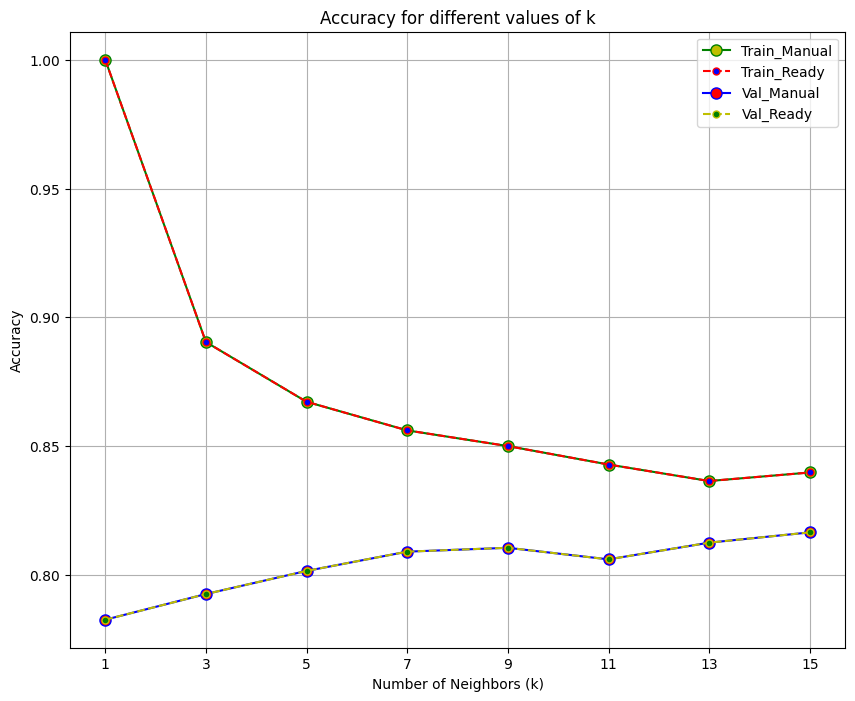

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(k_range, manual_model_train_accuarcies, marker='o', linestyle='-', color='g', markerfacecolor='y', markersize=8,label='Train_Manual')
plt.plot(k_range, ready_model_train_accuarcies, marker='o', linestyle='--', color='r', markerfacecolor='b', markersize=5,label='Train_Ready')
plt.plot(k_range, manual_model_val_accuarcies, marker='o', linestyle='-', color='b', markerfacecolor='r', markersize=8,label='Val_Manual')
plt.plot(k_range, ready_model_val_accuarcies, marker='o', linestyle='--', color='y', markerfacecolor='g', markersize=5,label='Val_Ready')
plt.title('Accuracy for different values of k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(k_range)
plt.grid(True)
plt.show()

#### Accuracy, Confusion matrix and other evaluation metrics are exactly the same for both implementations

#### 